# Introduction to Pulse Generation with LasingLib
LasingLib is the core of all interactions with both the annealing simulation and physically annealing the chip. Laser pulses created with this library can be fired, measured, and refined in-simulation. Once satisfied, they can be compiled into Cycle Code into annealing patterns.

The core object of this library is the LaserPulse object. These represent lasing actions, and have a variety of attributes which envelope all the possible axes of manipulation one can employ with the physical laser.

As per usual, clicking an object and pressing *shift-tab* will open its docstring for more information.

In [1]:
import lasinglib as ll
import simulationlib as sl
import shapes

import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib widget

# initialize an environment to demonstrate pulses on

CHIP = sl.SimGrid(dimension=32, resolution=101, thickness=0.03, use_spar=False,
                  spar_thickness=0.5, spar_width=1)

SILICON = sl.Material(diffusivity=88, emissivity=0.09, specific_heat=0.7, density=0.002329002)

sim = sl.Simulation(CHIP, SILICON, duration=6, pulses=None, ambient_temp=300,
                    starting_temp=300, neumann_bc=True,
                    edge_derivative=0, sample_framerate=24, intended_pbs=1,
                    dense_logging=False, timestep_multi=0.75, radiation=True, progress_bar=True, silent=False)

Here's an example of a simple laser pulse with the following properties:
* Wait one second, then fire at full power for one second.
* Full power is two watts in the simulation. Note that when converting to cycle code, this is interpreted as the amount of current to send to the laser.
* Aim for the center of the chip.
* Use the default value of sigma for the beam's radially gaussian intensity distribution in the simulator.

In [2]:
ex_pulse = ll.LaserPulse(grid=CHIP, start=1, duration=1, position=CHIP.CENTERPOINT, power=2, sigma=ll.DEFAULT_LASER_SIGMA)
print(ex_pulse)

Pulse(2.000W, 1.000 + 1.000S -> 2.000NOMOD)


Note that the string representation of the pulse shows some important information. Full power of two watts, starting at one second, then holding for one second until a final end-time (in the simulation) of $t=2s$. "NOMOD" indicates that the beam's intensity is binary (on/off).

## Modulation

Let's make a more complicated pulse. This time, we'll add a modulation function to adjust the beam's intensity over time. This function $f(t)$ is evaluated at every simulation time point, and then multiplied by the beam's "power" attribute to give the actual output of the beam at that time.

Technically, any function with the signature `float, params (optional) -> float` will work as a modulator.

Generally, these functions should have the following characteristics:
* **Intended working domain over the duration of the pulse**: The beam should be modulated through its duration to avoid unexpected behavior.
* **Range of [0, 1]**: Negative beam power is obviously unphysical. Enforcing a maximum of 1 ensures that the maximum possible beam power is always known, and makes qualitative comparison of different functions i.e. in Desmos easier. When it comes to designing modulation patterns, Desmos is your friend. A small library of modulator-building functions can be found in the file `modulators.py`. When called, these will produce callables which can be plugged directly into a LaserPulse with no supporting parameters.

A LaserPulse can take an arbitrary number of modulation functions. The final modulation profile will be their multiplicative sum:

$P_{laser}(t) = P_{max} \prod_{i=0} f_{i}(t, params_{i})$

These functions are always evaluated on the **local** time of a pulse as opposed to that of the simulation. In other words, $t=0$ when the pulse is just beginning to fire.

Our new pulse will have the same base characteristics as the previous pulse, but it will rapidly oscillate in intensity. It will fire a second after our first pulse is done.

In [ ]:
def modulation_sinesquared(t, omega):
    # return a squared sine wave as a function as time.
    return np.sin(t * omega)**2

ex_pulse_modulated = ll.LaserPulse(grid=CHIP, start=3, duration=1, position=CHIP.CENTERPOINT, power=2, sigma=ll.DEFAULT_LASER_SIGMA,
                                     modulators=[modulation_sinesquared], params=[(9,)])

Let's take a look at our two pulses. We plug a list of them into sim.pulses:

In [ ]:
sim.pulses = [ex_pulse, ex_pulse_modulated]
sim.simulate()

ani = sim.animate(cmap="magma")
plt.close()
# use plt.show() for more rigorous examinations
HTML(ani.to_jshtml())

## LaserStrobes
A potentially useful subclass of LaserPulse is the LaserStrobe. These are used to simulate moving the beam over areas of the chip while still firing the laser. Unfortunately, the way galvometer control is currently implemented into TAP means that this doesn't produce the desired effect of "tracing" the beam. Because the motors move extremely quickly and we have no direct velocity control (cycle code commands and the underlying LABview code is done purely through sequences of positions), the beam will "teleport" between points instead of tracing a line.

Nonetheless, simulating strobes might lead to interesting insights. The only difference between them and the base LaserPulse is that their position is parameterized by two functions $x(t), y(t)$. These are passed as a tuple, and a collection of primitive adjustable shapes can be found in the module `shapes.py`. Strobes can also be modulated in the same way as LaserPulses.

In [ ]:
# traced circular pattern with radius 10 and angular velocity omega = 96pi
circle_parameterization = shapes.genericradial(omega=(96 * np.pi), r=(lambda t: 10), phase=-(np.pi / 2))

ex_strobe = ll.LaserStrobe(grid=CHIP, start=1, duration=3, position=CHIP.CENTERPOINT, power=6, sigma=ll.DEFAULT_LASER_SIGMA,
                           modulators=[modulation_sinesquared], params=[(9,)],
                           parameterization=circle_parameterization)
print(ex_strobe)

Visualizing:

In [ ]:
sim.pulses = [ex_strobe]
sim.simulate()

ani = sim.animate(cmap="magma")
plt.close()
# use plt.show() for more rigorous examinations
HTML(ani.to_jshtml())

## LaserSequences
Compiling and sorting large amounts of LaserPulses to create an annealing cycle can be tedious. The LaserSequence object addresses this by acting as a LaserPulse that takes an ordered list of pulses and their desired timings, then sequences them as desired. Delays between pulses can either be specified as a single value or an array of different delays per pulse.

The intended workflow with LaserSequences is to first build a list of individual LaserPulses dynamically, then build a LaserSequence based off of that list. For example: the following code would assemble a an annealing sequence that fires sequential pulses over a grid:

Unordered list of pulses:
[Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S -> 1.100NOMOD), Pulse(2.000W, 1.000 + 0.100S

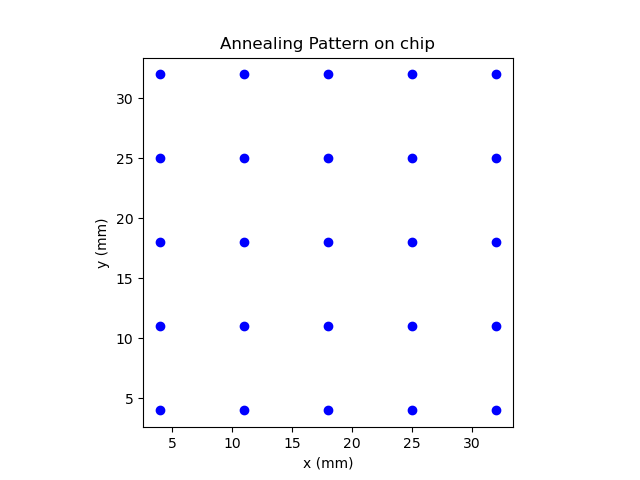

In [4]:
# number aranges to produce a grid
x_coords = np.arange(4, 33, 7)
y_coords = np.arange(4, 33, 7)

# use a lower-resolution SimGrid for a faster simulation so that you aren't here all day
chip_fast = sl.SimGrid(dimension=32, resolution=71, thickness=0.03, use_spar=False,
                  spar_thickness=0.5, spar_width=1)

# iterate over the grid, building a pulse for each location

pulses = []

for x in x_coords:
    for y in y_coords:
        # start time is arbitrary as the pulses will be arranged sequentially one put into a LaserSequence
        pulses.append(ll.LaserPulse(grid=chip_fast, start=1, duration=0.1, position=(x, y), power=2, sigma=ll.DEFAULT_LASER_SIGMA))

print(f"Unordered list of pulses:\n{pulses}\n")

pulse_sequence = ll.LaserSequence(pulses, delay=0.15, start_time=1)

print(f"Ordered LaserSequence:\n{pulse_sequence}\n")


fig, ax = plt.subplots()
plt.gca().set_aspect('equal')

ax.set_title("Annealing Pattern on chip")
ax.plot(pulse_sequence.trace_x, pulse_sequence.trace_y, "bo")
ax.set_ylabel("y (mm)")
ax.set_xlabel("x (mm)")
plt.show()

Visualizing the sequence (with a lower-resolution simulation for brevity):

In [ ]:
sim_fast = sl.Simulation(chip_fast, SILICON, duration=pulse_sequence.duration, pulses=None, ambient_temp=300,
                    starting_temp=300, neumann_bc=True,
                    edge_derivative=0, sample_framerate=24, intended_pbs=1,
                    dense_logging=False, timestep_multi=1, radiation=True, progress_bar=True, silent=False)

sim_fast.pulses = [pulse_sequence]
sim_fast.simulate()

ani = sim_fast.animate(cmap="magma")
plt.close()
# use plt.show() for more rigorous examinations
HTML(ani.to_jshtml())

## Compilation to Cycle Code and the Annealing Database

Once you have created the desired annealing cycle as a LaserSequence, you can compile it to "cycle code" for testing in the annealing chamber. Before doing so, you should confirm that the power settings you are using are correct. 

***Important note***: Note that cycle code and TAP works with laser output primarily in amps as opposed to watts. The LaserSequence cycle code compiler uses a lookup table to convert a target power to the current needed to achieve that output through the laser. The laser can output anywhere between 0.7-29.8W, but avoid going above 15W as you risk damaging the mirrors. This will still damage the chip if you are not careful. **Please do not send $30W$ into the actual chip!**

In [ ]:
 # Save the LaserPulse to cycle code under "example cycle code.txt"

CENTERING_OFFSETS = (-2, -1.5)

sample_interval = 0.05 # sample period if a pulse has some sort of parameterization (either or both position and current modulation)
pulse_sequence.write_to_cycle_code("./cycle code/example cycle code.txt", time_interval = sample_interval, *CENTERING_OFFSETS)

Note the parameter time_interval. If a pulse in the LaserSequence has any parameterized property (i.e. modulating amplitude over time), the compiler will sample the value of that modulation every `time_interval` seconds and write a new of cycle code. 

The `CENTERING_OFFSETS` are another important parameter that should be supplied for compilation. After automatic calibration, we manually translate the resulting coordinate system until it has approximate symmetry across the detector (i.e. the center point (16, 16) actually corresponds to the center of the detector. These offsets are provided in TAP's `settings.csv`: `pvcs_x_offset` and `pvcs_y_offset`, and the same values should be provided to `write_to_cycle_code`. Forgetting to do this may lead to confusing results. Unfortunately, this is currently a manually process... but you can change that!

***IMPORTANT***

While it may seem ideal to minimize `time_interval` for maximum temporal resolution, this can be problematic as the cycle code interpreter in TAP takes a non-zero amount of time to send new lines to the annealing system. This can lead to pulses lasting longer than expected as the annealing cycle gets bottlenecked by hardware latency.

Cycle code lines are formatted as:

$XVoltage, YVoltage, HoldTime, LaserCurrent$

$XVoltage$ and $YVoltage$ are values acquired through a calibrated Position-Voltage converter function. The calibration data is currently hard-coded to `calibratedPVCParameters - Copy.txt` as of July 2024. If the annealing chamber is ever re-calibrated, copy the calibration data from the TAP instance into here. 

Taking a look in the cycle code file, we see that each pulse has been translated into a series of on-off pulses at various locations in the chip.



In [3]:
with open("./cycle code/example cycle code.txt", "r") as f:
    print(f.readlines())

['-1.349,0.645,0.100,1.424\n', '-1.349,0.645,0.150,0.000\n', '-1.336,1.716,0.100,1.424\n', '-1.336,1.716,0.150,0.000\n', '-1.324,2.788,0.100,1.424\n', '-1.324,2.788,0.150,0.000\n', '-1.312,3.860,0.100,1.424\n', '-1.312,3.860,0.150,0.000\n', '-1.299,4.931,0.100,1.424\n', '-1.299,4.931,0.150,0.000\n', '-0.300,0.578,0.100,1.424\n', '-0.300,0.578,0.150,0.000\n', '-0.288,1.650,0.100,1.424\n', '-0.288,1.650,0.150,0.000\n', '-0.275,2.721,0.100,1.424\n', '-0.275,2.721,0.150,0.000\n', '-0.263,3.793,0.100,1.424\n', '-0.263,3.793,0.150,0.000\n', '-0.250,4.865,0.100,1.424\n', '-0.250,4.865,0.150,0.000\n', '0.749,0.512,0.100,1.424\n', '0.749,0.512,0.150,0.000\n', '0.761,1.583,0.100,1.424\n', '0.761,1.583,0.150,0.000\n', '0.774,2.655,0.100,1.424\n', '0.774,2.655,0.150,0.000\n', '0.786,3.726,0.100,1.424\n', '0.786,3.726,0.150,0.000\n', '0.799,4.798,0.100,1.424\n', '0.799,4.798,0.150,0.000\n', '1.798,0.445,0.100,1.424\n', '1.798,0.445,0.150,0.000\n', '1.810,1.517,0.100,1.424\n', '1.810,1.517,0.150,0.0

## The Annealing Database
It is important to keep track of what pulses have been applied to the chip in the past. The annealing development suite comes with a way to track these through the library `annealing_database`. 

Annealing databases are one-time-created pairs of a CSV file (the human readable database) and ChipRecord Python objects which hold the actual LaserPulse objects used in past pulses. The prior is serialized as a dill file.

The following would create a new database called `example_database`. You would only do this once per new chip or annealing sample. 

```python
adb2.new_chiprecord(name="example_database", path="./annealing records/example database/", dname="example_database.dill", csvname="example_database.csv")
```

To write to a database, initialize it with a DatabassWrapper instance pointing to the path of the database's dill file. You can then access the `ChipRecord` with `load_data()`, and by extension the pulse entry record `entry_data`. We will use a previously initalized database for this demonstration.


In [ ]:
import annealing_database2 as adb2
example_database_path = "./annealing records/example database/example_database.dill"


example_database = adb2.DatabaseWrapper(example_database_path)
print(example_database.load_data(), end="\n\n")
print(f"Entries: \n{example_database.load_entries()}", end="\n\n")

print(f"\nThis database is linked to {example_database.load_data().csvpath}.")
example_database.visualize();

## Editing the CSV File

If you open the associated csv file, you will find the same entries as are shown here. The CSV file is human-modifiable; you can add information to the Notes column or any other column as long as it correponds to the same row as a particular entry.

Line parity between the CSV file and the ChipRecord is maintained. Deleting lines from the CSV file will cause the corresponding entries in the ChipRecord to be deleted as well. The suggested program to open these CSV files with is Excel. This functionality is here to add the ability to remove invalid/unfired entries from the database.

## Writing to the database

Once you have an annealing sequence finalized and ready to be fired, add it to the database:

In [ ]:
example_database.write_sequence(pulse_sequence, notes="new annealing pattern")

In [ ]:
print(f"Entries: \n{example_database.load_entries()}", end="\n\n")
example_database.visualize()

## Database Backups
The database supports backups of previous states in case important information is deleted. This is janky however, and it may be better to first see if you can revert to a previous Git commit.

In [ ]:
print(list(example_database.get_backups()))

Backing up an instance is done with `backup()`

In [ ]:
last_backup_name = example_database.backup("new backup")  # this function returns the key of the backup made.
print(list(example_database.get_backups()))

You can load previous backups. Note: this deletes all un-backed-up entries - do a backup first if you are unsure.

In [ ]:
example_database.load_backup("Backup 10-25-2024, 16;16; pre-experimental backup.zip")
example_database.visualize()

Finally, database backups can also be deleted.

In [ ]:
example_database.delete_backup(last_backup_name)
print(list(example_database.get_backups()))